#**Lesson 5 and 7: implementation of a Random Forest**

##**Imports and connections**

In [0]:
#You can edit source code from modules and they will update accordingly
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Needed imports
import sys
from fastai.imports import *
from fastai.tabular import *

sys.path.insert(0, '/content/gdrive/My Drive/Colab Notebooks/L1RF')
from structured import *

# pandas???
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics

##**Data storage**

In [0]:
PATH = 'gdrive/My\ Drive/Colab\ Notebooks/L1RF/data/'

In [0]:
# Parse and store the data using a panda funtion, passing the path and a list of all the date columns
PATH = PATH.replace("\\", "")
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, parse_dates=["saledate"])
df_raw.SalePrice = np.log(df_raw.SalePrice)
add_datepart(df_raw, 'saledate')
train_cats(df_raw)
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [0]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [0]:
def split_vals(a, n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valids = split_vals(df_raw, n_trn)

In [0]:
cols = ['YearMade', 'MachineHoursCurrentMeter']
x_sub = X_train[cols]

##**Our own TreeEnsemble (Random Forest) class**

Lets start writing our RF with a top down aproach. This is good for OOP since we work with everyhting as if we had all the API's already and we start building them until we have everything we need.

In [0]:
class TreeEnsemble():
  #Simple constructor
  def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
    np.random.seed(42)
    self.x, self.y, self.n_trees, self.sample_sz, self.min_leaf = x, y, n_trees, sample_sz, min_leaf
    # create list of n_trees
    self.trees = [self.create_tree() for i in range(n_trees)]

  #create_tree method, used by contructror
  def create_tree(self):
    #create a random permutation of from [0, len(y)) and take the first sample_sz elements as our idxs
    idxs = np.random.permutation(len(self.y))[:self.sample_sz]
    #return a DesicionTree created with such elements
    return DecisionTree(self.x.iloc[idxs], self.y[idxs], min_leaf = self.min_leaf)
  #prediction funciton for a row
  def predict(self, x):
    #return the mean of each individual prediction for every tree
    return np.mean([t.predict(x) for t in self.trees], axis = 0)

In [0]:
class DecisionTree():
  def __init__(self, x, y, idxs=None, min_leaf=5):
    if idxs is None: idxs = np.arange(len(y))
    self.x, self.y, self.idxs, self.min_leaf = x, y, idxs, min_leaf
    self.n, self.c = len(idxs), x.shape[1]
    self.val = np.mean(y[idxs])
    self.score = float('inf')
    self.find_varsplit()

  def predict(self, x): return np.array([self.predict_row(xi) for xi in x])
  
  def predict_row(self, xi):
    if self.is_leaf: return self.val
    next_tree = self.lhs if xi[self.var_idx]<=self.split else self.rhs
    return next_tree.predict_row(xi)

  #Method that helps us find the best split for our node iterating over all the
  #features and trying all of them.
  def find_varsplit(self):
    for i in range(self.c): self.find_better_split(i)
    if self.is_leaf: return
    x = self.split_col
    lhs = np.nonzero(x<=self.split)[0]
    rhs = np.nonzero(x>self.split)[0]
    #print(lhs.shape, ' ', rhs.shape)
    self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
    self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])
  

  #Method that given n elements, sum of the elements and the sum of the square
  #of such elements helps us calulate the std deviation for such group.
  def std_def_cont(self, n, s1, s2): return math.sqrt(s2/n - (s1/n)**2)


  #Method that finds the best split for a signle feature
  def find_better_split(self, var_idx):

    #separate our x values to be only the ones in the idx of this node and from
    #the current variable (column or feature) and same for our y
    x, y = self.x.values[self.idxs, var_idx], self.y[self.idxs]

    #sort the values
    sort_idx = np.argsort(x)
    sort_y, sort_x = y[sort_idx], x[sort_idx]

    #auxiliar variables to calculate our standard deviation
    right_s, right_s2 = sort_y.sum(), (sort_y**2).sum()
    left_s, left_s2 = 0., 0.

    #Minimizing the standard deviation of both of our groups is matemathically
    #the same as minimizing the RMSE of both of them. Here we calculate what
    for i in range(0, self.n-self.min_leaf-1):
      xi, yi = sort_x[i], sort_y[i]
      left_s += yi; right_s -= yi
      left_s2 += yi**2; right_s2 -= yi**2
      if i < self.min_leaf or xi == sort_x[i+1]:
        continue
      left_std = self.std_def_cont(i+1, left_s, left_s2)
      right_std = self.std_def_cont(self.n-i-1, right_s, right_s2)
      curr_score = left_std*(i+1) + right_std*(self.n-i-1)

      if curr_score<self.score:
        self.var_idx, self.score, self.split = var_idx, curr_score, xi

  
  @property
  def split_name(self): return self.x.columns[self.var_idx]

  
  @property
  def split_col(self): return self.x.values[self.idxs, self.var_idx]

  
  @property
  def is_leaf(self): return self.score == float('inf')

  
  #method that allows us to print this object
  def __repr__(self):
    s = f'n: {self.n}; val:{self.val}'
    if not self.is_leaf:
      s += f': score:{self.score}; split:{self.split} var:{self.split_name}'
    return s

##**Testing and comparision to sklearn's RF**

Nos lets create the comparission one, the RandomForestRegressor from sklearn

In [0]:
tree_ensemble = TreeEnsemble(x_sub, y_train, 1, 1000)
tree = tree_ensemble.trees[0]
x_samp, y_samp = tree.x, tree.y
x_samp.columns

Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object')

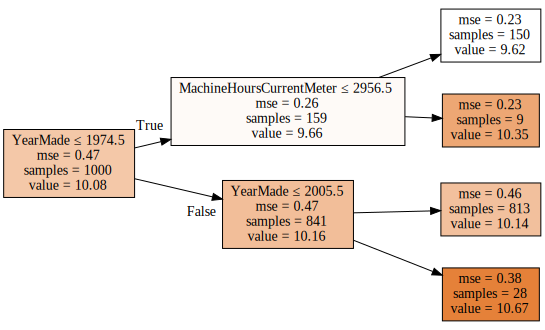

In [0]:
model_s = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
model_s.fit(x_samp, y_samp)
draw_tree(model_s.estimators_[0], x_samp, precision=2)

In [0]:
print(tree)
print(tree.lhs)
print(tree.rhs)
print(tree.lhs.lhs)
print(tree.rhs.rhs)

n: 1000; val:10.079014121552744: score:658.5510186055565; split:1974.0 var:YearMade
n: 159; val:9.660892662981706: score:76.82696888346362; split:2800.0 var:MachineHoursCurrentMeter
n: 841; val:10.158064432982941: score:571.4803525045031; split:2005.0 var:YearMade
n: 150; val:9.619280538108496: score:71.15906938383463; split:1000.0 var:YearMade
n: 28; val:10.669849650935848: score:16.460871194578985; split:895.0 var:MachineHoursCurrentMeter


##**Testing our accuracy**

In [0]:
cols = ['MachineID', 'YearMade', 'MachineHoursCurrentMeter', 'ProductSize', 'Enclosure', 'Coupler_System', 'saleYear']
X_train.saleYear.mean()

2003.8918496627048

In [0]:
ens = TreeEnsemble(X_train[cols], y_train, 5, 1000)
tree = ens.trees[0]
x_samp, y_samp = tree.x, tree.y
X_train[cols]

,MachineID,YearMade,MachineHoursCurrentMeter,ProductSize,Enclosure,Coupler_System,saleYear
0,999089,2004,68.0,0,3,0,2006
1,117657,1996,4640.0,4,3,0,2004
2,434808,2001,2838.0,0,6,1,2004
3,1026470,2001,3486.0,6,3,0,2011
4,1057373,2007,722.0,0,1,1,2009
...,...,...,...,...,...,...,...
389120,1789509,1998,5388.0,6,3,0,2011
389121,1789509,2003,7426.0,6,3,0,2011
389122,1789509,2003,4223.0,0,3,0,2011
389123,2296205,1999,2552.0,5,1,0,2010


In [0]:
preds = tree.predict(X_valid[cols].values)

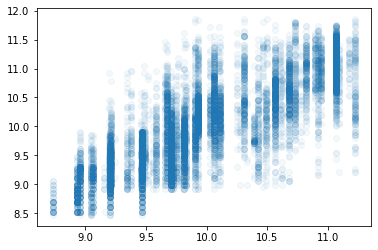

In [0]:
plt.scatter(preds, y_valid, alpha=0.05)

In [0]:
metrics.r2_score(y_valid, preds)

0.6389029210346325

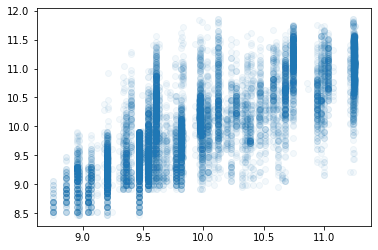

In [0]:
model = RandomForestRegressor(n_estimators=1, min_samples_leaf=5, bootstrap=False)
model.fit(x_samp, y_samp)
preds = model.predict(X_valid[cols].values)
plt.scatter(preds, y_valid, alpha=0.05)

In [0]:
metrics.r2_score(y_valid, preds)

0.5769595726471153

In [0]:
preds = ens.predict(X_valid[cols].values)

In [0]:
metrics.r2_score(y_valid, preds)

0.7101174157107124